<a href="https://colab.research.google.com/github/vageeshmaiya/Deep-Learning-based-Battery-Synthetic-Data/blob/main/Deep_AR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Darts Deep_AR

#### Installing Darts

In [1]:
pip install darts

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from os.path import dirname, basename
from os import getcwd
import sys

In [3]:
def fix_pythonpath_if_working_locally():
    """Add the parent path to pythonpath if current working dir is darts/examples"""
    cwd = getcwd()
    if basename(cwd) == 'examples':
        sys.path.insert(0, dirname(cwd))


In [4]:
get_ipython().run_line_magic('load_ext', 'autoreload')
get_ipython().run_line_magic('autoreload', '2')
get_ipython().run_line_magic('matplotlib', 'inline')

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import shutil
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm_notebook as tqdm

from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.models import RNNModel, ExponentialSmoothing, BlockRNNModel
from darts.metrics import mape
from darts.utils.statistics import check_seasonality, plot_acf
import darts.utils.timeseries_generation as tg
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.missing_values import fill_missing_values
from darts.utils.likelihood_models import GaussianLikelihood

In [6]:
import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)

#### Uploading Dataset



1.   Make sure to upload the dataset to be used in google drive
2.   Makw the necessary changes in the path by copying the path of the dataset uploaded



In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
path = "/content/drive/MyDrive/dataset4.csv"
df = pd.read_csv(path)

In [9]:
df['Date_Time'] = pd.to_datetime(df['Date_Time'])

In [12]:
# Coloumns can be dropped as per requirement
# Uncomment to drop required coloumns
#df = df.drop('Charge_Capacity(Ah)',axis=1) 

#### Creating timeseries data and Scaling the data 

In [13]:
ser = TimeSeries.from_dataframe(df=df,time_col="Date_Time")

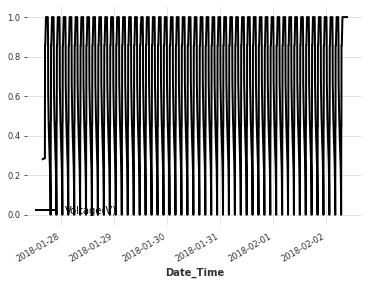

In [14]:
scaler_en = Scaler()
series_en_transformed = scaler_en.fit_transform(ser)
train_en_transformed, val_en_transformed = series_en_transformed.split_after(pd.Timestamp('1/30/2018  10:26:10 AM'))
series_en_transformed.plot()

#### Creating the Model

In [15]:
model_en = RNNModel(
    model='LSTM',
    hidden_dim=20,
    n_rnn_layers=2,
    dropout=0.2,
    batch_size=16,
    n_epochs=100,
    optimizer_kwargs={'lr': 1e-3},
    random_state=42,
    training_length=243,
    input_chunk_length=162,
    likelihood=GaussianLikelihood()
)

model_en.fit(series=train_en_transformed, 
             verbose=True)

Training: 0it [00:00, ?it/s]

Predicting: 110it [00:00, ?it/s]

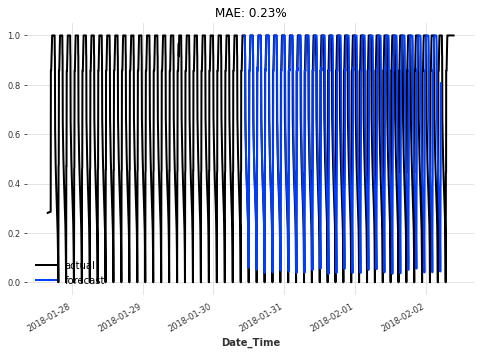

In [18]:
from darts.metrics import mae

def eval_model(model):
    pred_series = model.predict(n=2000)
    plt.figure(figsize=(8,5))
    series_en_transformed.plot(label='actual')
    pred_series.plot(label='forecast')
    plt.title('MAE: {:.2f}%'.format(mae(pred_series, val_en_transformed)))
    plt.legend()
    
    plt.savefig("darts_deepAR_6_cycles.pdf",bbox_inches="tight")
    
eval_model(model_en)

#### Backtesting

In [19]:
backtest_en = model_en.historical_forecasts(series=series_en_transformed,
                                            num_samples=50,
                                            start=0.7,
                                            forecast_horizon=500,
                                            stride=5,
                                            retrain=False,
                                            verbose=True)

  0%|          | 0/149 [00:00<?, ?it/s]

Predicting: 110it [00:00, ?it/s]

  1%|          | 1/149 [00:00<01:38,  1.50it/s]

Predicting: 110it [00:00, ?it/s]

  1%|▏         | 2/149 [00:01<01:25,  1.72it/s]

Predicting: 110it [00:00, ?it/s]

  2%|▏         | 3/149 [00:01<01:21,  1.80it/s]

Predicting: 110it [00:00, ?it/s]

  3%|▎         | 4/149 [00:02<01:18,  1.84it/s]

Predicting: 110it [00:00, ?it/s]

  3%|▎         | 5/149 [00:02<01:17,  1.86it/s]

Predicting: 110it [00:00, ?it/s]

  4%|▍         | 6/149 [00:03<01:17,  1.86it/s]

Predicting: 110it [00:00, ?it/s]

  5%|▍         | 7/149 [00:03<01:16,  1.86it/s]

Predicting: 110it [00:00, ?it/s]

  5%|▌         | 8/149 [00:04<01:15,  1.87it/s]

Predicting: 110it [00:00, ?it/s]

  6%|▌         | 9/149 [00:04<01:15,  1.85it/s]

Predicting: 110it [00:00, ?it/s]

  7%|▋         | 10/149 [00:05<01:14,  1.86it/s]

Predicting: 110it [00:00, ?it/s]

  7%|▋         | 11/149 [00:05<01:13,  1.87it/s]

Predicting: 110it [00:00, ?it/s]

  8%|▊         | 12/149 [00:06<01:12,  1.88it/s]

Predicting: 110it [00:00, ?it/s]

  9%|▊         | 13/149 [00:07<01:11,  1.89it/s]

Predicting: 110it [00:00, ?it/s]

  9%|▉         | 14/149 [00:07<01:11,  1.89it/s]

Predicting: 110it [00:00, ?it/s]

 10%|█         | 15/149 [00:08<01:11,  1.87it/s]

Predicting: 110it [00:00, ?it/s]

 11%|█         | 16/149 [00:08<01:11,  1.87it/s]

Predicting: 110it [00:00, ?it/s]

 11%|█▏        | 17/149 [00:09<01:10,  1.87it/s]

Predicting: 110it [00:00, ?it/s]

 12%|█▏        | 18/149 [00:09<01:09,  1.89it/s]

Predicting: 110it [00:00, ?it/s]

 13%|█▎        | 19/149 [00:10<01:09,  1.87it/s]

Predicting: 110it [00:00, ?it/s]

 13%|█▎        | 20/149 [00:10<01:08,  1.87it/s]

Predicting: 110it [00:00, ?it/s]

 14%|█▍        | 21/149 [00:11<01:08,  1.87it/s]

Predicting: 110it [00:00, ?it/s]

 15%|█▍        | 22/149 [00:11<01:08,  1.86it/s]

Predicting: 110it [00:00, ?it/s]

 15%|█▌        | 23/149 [00:12<01:08,  1.83it/s]

Predicting: 110it [00:00, ?it/s]

 16%|█▌        | 24/149 [00:12<01:08,  1.83it/s]

Predicting: 110it [00:00, ?it/s]

 17%|█▋        | 25/149 [00:13<01:07,  1.84it/s]

Predicting: 110it [00:00, ?it/s]

 17%|█▋        | 26/149 [00:14<01:07,  1.82it/s]

Predicting: 110it [00:00, ?it/s]

 18%|█▊        | 27/149 [00:14<01:07,  1.81it/s]

Predicting: 110it [00:00, ?it/s]

 19%|█▉        | 28/149 [00:15<01:08,  1.78it/s]

Predicting: 110it [00:00, ?it/s]

 19%|█▉        | 29/149 [00:15<01:07,  1.79it/s]

Predicting: 110it [00:00, ?it/s]

 20%|██        | 30/149 [00:16<01:05,  1.81it/s]

Predicting: 110it [00:00, ?it/s]

 21%|██        | 31/149 [00:16<01:04,  1.82it/s]

Predicting: 110it [00:00, ?it/s]

 21%|██▏       | 32/149 [00:17<01:04,  1.82it/s]

Predicting: 110it [00:00, ?it/s]

 22%|██▏       | 33/149 [00:17<01:02,  1.84it/s]

Predicting: 110it [00:00, ?it/s]

 23%|██▎       | 34/149 [00:18<01:02,  1.85it/s]

Predicting: 110it [00:00, ?it/s]

 23%|██▎       | 35/149 [00:19<01:01,  1.85it/s]

Predicting: 110it [00:00, ?it/s]

 24%|██▍       | 36/149 [00:19<01:00,  1.86it/s]

Predicting: 110it [00:00, ?it/s]

 25%|██▍       | 37/149 [00:20<01:00,  1.84it/s]

Predicting: 110it [00:00, ?it/s]

 26%|██▌       | 38/149 [00:20<01:00,  1.84it/s]

Predicting: 110it [00:00, ?it/s]

 26%|██▌       | 39/149 [00:21<00:59,  1.84it/s]

Predicting: 110it [00:00, ?it/s]

 27%|██▋       | 40/149 [00:21<01:00,  1.81it/s]

Predicting: 110it [00:00, ?it/s]

 28%|██▊       | 41/149 [00:22<00:59,  1.81it/s]

Predicting: 110it [00:00, ?it/s]

 28%|██▊       | 42/149 [00:22<00:58,  1.83it/s]

Predicting: 110it [00:00, ?it/s]

 29%|██▉       | 43/149 [00:23<00:57,  1.83it/s]

Predicting: 110it [00:00, ?it/s]

 30%|██▉       | 44/149 [00:23<00:56,  1.85it/s]

Predicting: 110it [00:00, ?it/s]

 30%|███       | 45/149 [00:24<00:56,  1.85it/s]

Predicting: 110it [00:00, ?it/s]

 31%|███       | 46/149 [00:24<00:55,  1.85it/s]

Predicting: 110it [00:00, ?it/s]

 32%|███▏      | 47/149 [00:25<00:55,  1.84it/s]

Predicting: 110it [00:00, ?it/s]

 32%|███▏      | 48/149 [00:26<00:55,  1.83it/s]

Predicting: 110it [00:00, ?it/s]

 33%|███▎      | 49/149 [00:26<00:54,  1.84it/s]

Predicting: 110it [00:00, ?it/s]

 34%|███▎      | 50/149 [00:27<00:53,  1.85it/s]

Predicting: 110it [00:00, ?it/s]

 34%|███▍      | 51/149 [00:27<00:53,  1.84it/s]

Predicting: 110it [00:00, ?it/s]

 35%|███▍      | 52/149 [00:28<00:52,  1.86it/s]

Predicting: 110it [00:00, ?it/s]

 36%|███▌      | 53/149 [00:28<00:51,  1.86it/s]

Predicting: 110it [00:00, ?it/s]

 36%|███▌      | 54/149 [00:29<00:50,  1.88it/s]

Predicting: 110it [00:00, ?it/s]

 37%|███▋      | 55/149 [00:29<00:50,  1.87it/s]

Predicting: 110it [00:00, ?it/s]

 38%|███▊      | 56/149 [00:30<00:49,  1.87it/s]

Predicting: 110it [00:00, ?it/s]

 38%|███▊      | 57/149 [00:30<00:49,  1.85it/s]

Predicting: 110it [00:00, ?it/s]

 39%|███▉      | 58/149 [00:31<00:49,  1.83it/s]

Predicting: 110it [00:00, ?it/s]

 40%|███▉      | 59/149 [00:32<00:49,  1.83it/s]

Predicting: 110it [00:00, ?it/s]

 40%|████      | 60/149 [00:32<00:48,  1.83it/s]

Predicting: 110it [00:00, ?it/s]

 41%|████      | 61/149 [00:33<00:48,  1.83it/s]

Predicting: 110it [00:00, ?it/s]

 42%|████▏     | 62/149 [00:33<00:47,  1.83it/s]

Predicting: 110it [00:00, ?it/s]

 42%|████▏     | 63/149 [00:34<00:46,  1.84it/s]

Predicting: 110it [00:00, ?it/s]

 43%|████▎     | 64/149 [00:34<00:46,  1.83it/s]

Predicting: 110it [00:00, ?it/s]

 44%|████▎     | 65/149 [00:35<00:45,  1.83it/s]

Predicting: 110it [00:00, ?it/s]

 44%|████▍     | 66/149 [00:35<00:45,  1.82it/s]

Predicting: 110it [00:00, ?it/s]

 45%|████▍     | 67/149 [00:36<00:44,  1.84it/s]

Predicting: 110it [00:00, ?it/s]

 46%|████▌     | 68/149 [00:36<00:44,  1.83it/s]

Predicting: 110it [00:00, ?it/s]

 46%|████▋     | 69/149 [00:37<00:43,  1.84it/s]

Predicting: 110it [00:00, ?it/s]

 47%|████▋     | 70/149 [00:38<00:43,  1.82it/s]

Predicting: 110it [00:00, ?it/s]

 48%|████▊     | 71/149 [00:38<00:43,  1.81it/s]

Predicting: 110it [00:00, ?it/s]

 48%|████▊     | 72/149 [00:39<00:42,  1.82it/s]

Predicting: 110it [00:00, ?it/s]

 49%|████▉     | 73/149 [00:39<00:41,  1.83it/s]

Predicting: 110it [00:00, ?it/s]

 50%|████▉     | 74/149 [00:40<00:41,  1.83it/s]

Predicting: 110it [00:00, ?it/s]

 50%|█████     | 75/149 [00:40<00:40,  1.83it/s]

Predicting: 110it [00:00, ?it/s]

 51%|█████     | 76/149 [00:41<00:39,  1.83it/s]

Predicting: 110it [00:00, ?it/s]

 52%|█████▏    | 77/149 [00:41<00:39,  1.82it/s]

Predicting: 110it [00:00, ?it/s]

 52%|█████▏    | 78/149 [00:42<00:38,  1.83it/s]

Predicting: 110it [00:00, ?it/s]

 53%|█████▎    | 79/149 [00:42<00:38,  1.83it/s]

Predicting: 110it [00:00, ?it/s]

 54%|█████▎    | 80/149 [00:43<00:37,  1.85it/s]

Predicting: 110it [00:00, ?it/s]

 54%|█████▍    | 81/149 [00:44<00:37,  1.82it/s]

Predicting: 110it [00:00, ?it/s]

 55%|█████▌    | 82/149 [00:44<00:36,  1.82it/s]

Predicting: 110it [00:00, ?it/s]

 56%|█████▌    | 83/149 [00:45<00:36,  1.82it/s]

Predicting: 110it [00:00, ?it/s]

 56%|█████▋    | 84/149 [00:45<00:35,  1.82it/s]

Predicting: 110it [00:00, ?it/s]

 57%|█████▋    | 85/149 [00:46<00:35,  1.80it/s]

Predicting: 110it [00:00, ?it/s]

 58%|█████▊    | 86/149 [00:46<00:34,  1.82it/s]

Predicting: 110it [00:00, ?it/s]

 58%|█████▊    | 87/149 [00:47<00:34,  1.82it/s]

Predicting: 110it [00:00, ?it/s]

 59%|█████▉    | 88/149 [00:47<00:33,  1.80it/s]

Predicting: 110it [00:00, ?it/s]

 60%|█████▉    | 89/149 [00:48<00:41,  1.46it/s]

Predicting: 110it [00:00, ?it/s]

 60%|██████    | 90/149 [00:49<00:46,  1.28it/s]

Predicting: 110it [00:00, ?it/s]

 61%|██████    | 91/149 [00:50<00:48,  1.18it/s]

Predicting: 110it [00:00, ?it/s]

 62%|██████▏   | 92/149 [00:51<00:42,  1.33it/s]

Predicting: 110it [00:00, ?it/s]

 62%|██████▏   | 93/149 [00:52<00:38,  1.44it/s]

Predicting: 110it [00:00, ?it/s]

 63%|██████▎   | 94/149 [00:52<00:36,  1.52it/s]

Predicting: 110it [00:00, ?it/s]

 64%|██████▍   | 95/149 [00:53<00:33,  1.60it/s]

Predicting: 110it [00:00, ?it/s]

 64%|██████▍   | 96/149 [00:53<00:32,  1.65it/s]

Predicting: 110it [00:00, ?it/s]

 65%|██████▌   | 97/149 [00:54<00:30,  1.70it/s]

Predicting: 110it [00:00, ?it/s]

 66%|██████▌   | 98/149 [00:54<00:29,  1.74it/s]

Predicting: 110it [00:00, ?it/s]

 66%|██████▋   | 99/149 [00:55<00:28,  1.75it/s]

Predicting: 110it [00:00, ?it/s]

 67%|██████▋   | 100/149 [00:55<00:27,  1.75it/s]

Predicting: 110it [00:00, ?it/s]

 68%|██████▊   | 101/149 [00:56<00:27,  1.76it/s]

Predicting: 110it [00:00, ?it/s]

 68%|██████▊   | 102/149 [00:57<00:26,  1.78it/s]

Predicting: 110it [00:00, ?it/s]

 69%|██████▉   | 103/149 [00:57<00:25,  1.79it/s]

Predicting: 110it [00:00, ?it/s]

 70%|██████▉   | 104/149 [00:58<00:24,  1.81it/s]

Predicting: 110it [00:00, ?it/s]

 70%|███████   | 105/149 [00:58<00:24,  1.82it/s]

Predicting: 110it [00:00, ?it/s]

 71%|███████   | 106/149 [00:59<00:23,  1.80it/s]

Predicting: 110it [00:00, ?it/s]

 72%|███████▏  | 107/149 [00:59<00:23,  1.79it/s]

Predicting: 110it [00:00, ?it/s]

 72%|███████▏  | 108/149 [01:00<00:22,  1.80it/s]

Predicting: 110it [00:00, ?it/s]

 73%|███████▎  | 109/149 [01:00<00:22,  1.78it/s]

Predicting: 110it [00:00, ?it/s]

 74%|███████▍  | 110/149 [01:01<00:21,  1.78it/s]

Predicting: 110it [00:00, ?it/s]

 74%|███████▍  | 111/149 [01:02<00:21,  1.79it/s]

Predicting: 110it [00:00, ?it/s]

 75%|███████▌  | 112/149 [01:02<00:20,  1.78it/s]

Predicting: 110it [00:00, ?it/s]

 76%|███████▌  | 113/149 [01:03<00:20,  1.79it/s]

Predicting: 110it [00:00, ?it/s]

 77%|███████▋  | 114/149 [01:03<00:19,  1.76it/s]

Predicting: 110it [00:00, ?it/s]

 77%|███████▋  | 115/149 [01:04<00:19,  1.78it/s]

Predicting: 110it [00:00, ?it/s]

 78%|███████▊  | 116/149 [01:04<00:18,  1.77it/s]

Predicting: 110it [00:00, ?it/s]

 79%|███████▊  | 117/149 [01:05<00:18,  1.76it/s]

Predicting: 110it [00:00, ?it/s]

 79%|███████▉  | 118/149 [01:06<00:17,  1.77it/s]

Predicting: 110it [00:00, ?it/s]

 80%|███████▉  | 119/149 [01:06<00:16,  1.77it/s]

Predicting: 110it [00:00, ?it/s]

 81%|████████  | 120/149 [01:07<00:16,  1.76it/s]

Predicting: 110it [00:00, ?it/s]

 81%|████████  | 121/149 [01:07<00:15,  1.77it/s]

Predicting: 110it [00:00, ?it/s]

 82%|████████▏ | 122/149 [01:08<00:15,  1.76it/s]

Predicting: 110it [00:00, ?it/s]

 83%|████████▎ | 123/149 [01:08<00:14,  1.75it/s]

Predicting: 110it [00:00, ?it/s]

 83%|████████▎ | 124/149 [01:09<00:14,  1.74it/s]

Predicting: 110it [00:00, ?it/s]

 84%|████████▍ | 125/149 [01:10<00:13,  1.74it/s]

Predicting: 110it [00:00, ?it/s]

 85%|████████▍ | 126/149 [01:10<00:13,  1.74it/s]

Predicting: 110it [00:00, ?it/s]

 85%|████████▌ | 127/149 [01:11<00:12,  1.74it/s]

Predicting: 110it [00:00, ?it/s]

 86%|████████▌ | 128/149 [01:11<00:11,  1.77it/s]

Predicting: 110it [00:00, ?it/s]

 87%|████████▋ | 129/149 [01:12<00:11,  1.77it/s]

Predicting: 110it [00:00, ?it/s]

 87%|████████▋ | 130/149 [01:12<00:10,  1.74it/s]

Predicting: 110it [00:00, ?it/s]

 88%|████████▊ | 131/149 [01:13<00:10,  1.76it/s]

Predicting: 110it [00:00, ?it/s]

 89%|████████▊ | 132/149 [01:13<00:09,  1.76it/s]

Predicting: 110it [00:00, ?it/s]

 89%|████████▉ | 133/149 [01:14<00:08,  1.78it/s]

Predicting: 110it [00:00, ?it/s]

 90%|████████▉ | 134/149 [01:15<00:08,  1.78it/s]

Predicting: 110it [00:00, ?it/s]

 91%|█████████ | 135/149 [01:15<00:07,  1.78it/s]

Predicting: 110it [00:00, ?it/s]

 91%|█████████▏| 136/149 [01:16<00:07,  1.77it/s]

Predicting: 110it [00:00, ?it/s]

 92%|█████████▏| 137/149 [01:16<00:06,  1.78it/s]

Predicting: 110it [00:00, ?it/s]

 93%|█████████▎| 138/149 [01:17<00:06,  1.79it/s]

Predicting: 110it [00:00, ?it/s]

 93%|█████████▎| 139/149 [01:17<00:05,  1.79it/s]

Predicting: 110it [00:00, ?it/s]

 94%|█████████▍| 140/149 [01:18<00:05,  1.80it/s]

Predicting: 110it [00:00, ?it/s]

 95%|█████████▍| 141/149 [01:19<00:04,  1.80it/s]

Predicting: 110it [00:00, ?it/s]

 95%|█████████▌| 142/149 [01:19<00:03,  1.80it/s]

Predicting: 110it [00:00, ?it/s]

 96%|█████████▌| 143/149 [01:20<00:03,  1.78it/s]

Predicting: 110it [00:00, ?it/s]

 97%|█████████▋| 144/149 [01:20<00:02,  1.78it/s]

Predicting: 110it [00:00, ?it/s]

 97%|█████████▋| 145/149 [01:21<00:02,  1.76it/s]

Predicting: 110it [00:00, ?it/s]

 98%|█████████▊| 146/149 [01:21<00:01,  1.75it/s]

Predicting: 110it [00:00, ?it/s]

 99%|█████████▊| 147/149 [01:22<00:01,  1.72it/s]

Predicting: 110it [00:00, ?it/s]

 99%|█████████▉| 148/149 [01:23<00:00,  1.75it/s]

Predicting: 110it [00:00, ?it/s]

100%|██████████| 149/149 [01:23<00:00,  1.78it/s]


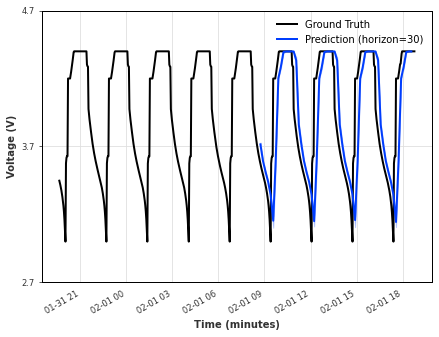

In [30]:
plt.figure(figsize=(7,5),edgecolor="black")
ax = plt.axes()
scaler_en.inverse_transform(series_en_transformed)[2995:3690].plot(label='Ground Truth')
scaler_en.inverse_transform(backtest_en)[0:60].plot(
    label='Prediction (horizon=30)', 
    low_quantile=0.01, 
    high_quantile=0.99)
plt.legend();
plt.xlabel('Time (minutes)')
plt.ylabel('Voltage (V)')
plt.yticks(np.arange(2.7,5.7))
ax.spines['top'].set_visible(True)
ax.spines['right'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
#plt.savefig("ChargeCapacity_Dataset4_horizon30_deepAR.pdf",bbox_inches="tight")

#### Calculating the mae values

In [23]:
mae(series_en_transformed, backtest_en)

0.19237844655900102

In [24]:
horizon = [10,30,50,80,100,200,300,400,500,600,700,800,900,1000] 
mae_voltage = [0.028240742225291323,0.03547731229501051,0.04344310391205137,0.04400652467326994,0.048100459340481745,0.06253215910141811,0.07706666575102646,0.10093288643900705,0.11987181930375958,0.1368720073684441,0.1544686256187071,0.18358829242283906,0.19671005450972537,0.22195815399518584]
mae_chargecapacity = [0.01858019844450955,0.05057368232783319,0.06815149476276788,0.06167047452813972,0.09000938761613485,0.14842236463693514,0.18415400735562212,0.21761887794608506,0.23387743856649765,0.2738795186671694,0.2880329654293883,0.28689844597817876,0.30570481318795645,0.30828611646741305]

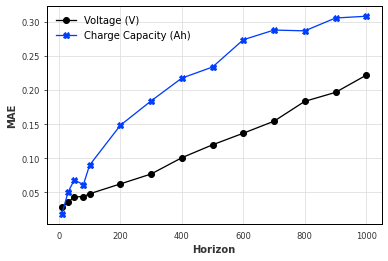

In [25]:
fig,ax = plt.subplots()
ax.spines['top'].set_visible(True)
ax.spines['right'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.plot(horizon,mae_voltage,marker = "o",label = "Voltage (V)")
ax.plot(horizon,mae_chargecapacity,marker = "X",label = "Charge Capacity (Ah)")
ax.set_xlabel('Horizon')
ax.set_ylabel('MAE')
plt.legend()
plt.savefig("darts_deepar_mae_vs_horizon_dataset4.pdf",bbox_inches="tight")